In [199]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import copy

In [200]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [201]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [202]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = copy.deepcopy(big_pv_geoms_32632)
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)


print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [214]:
for i, geom in big_pv_geoms_buffer.iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
        
        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        #data_filled['crs'] = data.crs
        data.rio.write_crs("epsg:32633", inplace=True) #32633

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)

        ## Clip the farm polygon
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        break        
    except:
         print(f"This polygon id: {i} is not exist.")

This polygon id: 0 is not exist.
This polygon id: 1 is not exist.


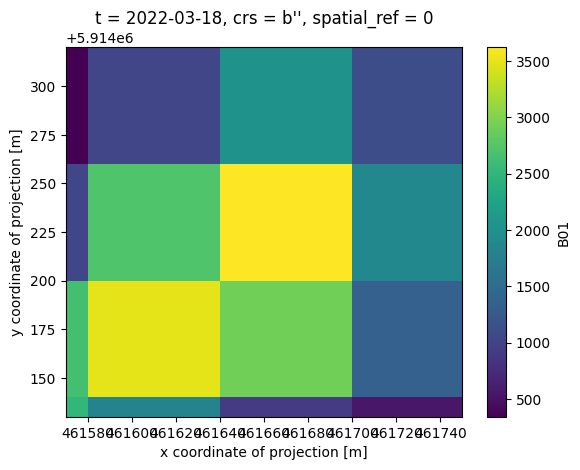

In [215]:
data['B01'][30].plot()

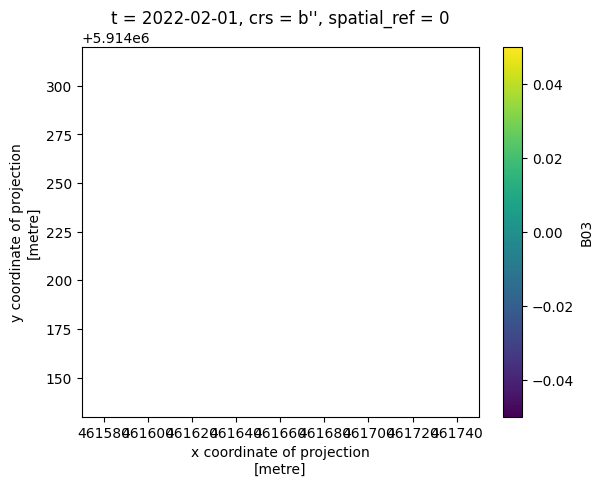

In [216]:
clipped['B03'][12].plot()

In [217]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

In [218]:
data_dir

'/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[280:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{i}.nc",decode_coords="all")
              
        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 280 is not exist.
This polygon id: 282 is not exist.
This polygon id: 284 is not exist.
This polygon id: 287 is not exist.
This polygon id: 288 is not exist.
This polygon id: 294 is not exist.
This polygon id: 307 is not exist.
This polygon id: 308 is not exist.
This polygon id: 315 is not exist.
This polygon id: 328 is not exist.
This polygon id: 342 is not exist.
This polygon id: 344 is not exist.
This polygon id: 348 is not exist.
This polygon id: 350 is not exist.
This polygon id: 351 is not exist.
This polygon id: 353 is not exist.
This polygon id: 356 is not exist.
This polygon id: 365 is not exist.
This polygon id: 375 is not exist.
This polygon id: 376 is not exist.
This polygon id: 377 is not exist.
This polygon id: 386 is not exist.
This polygon id: 390 is not exist.
This polygon id: 400 is not exist.
This polygon id: 403 is not exist.
This polygon id: 414 is not exist.
This polygon id: 422 is not exist.
This polygon id: 424 is not exist.
This polygon id: 425

In [24]:
pv_samples = np.vstack(all_pixels_ts)
pv_samples.shape

(8060, 11, 365)

In [25]:
y1 = np.ones(pv_samples.shape[0])

In [26]:
# Extract S2 data for the photvoltaic farms - pixels outside the polygons "labels as 0"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[5:].iterrows():
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=True)

        df = clipped.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))   
    except:
        print(f"This polygon id: {i} is not exist.")

This polygon id: 800 is not exist.


In [27]:
non_pv_samples = np.vstack(all_pixels_ts)
non_pv_samples.shape

(22551, 11, 365)

In [28]:
y0 = np.zeros(non_pv_samples.shape[0])

#### Combine both PV and Non-PV togehter 

In [173]:
tr_data = np.vstack([pv_samples, non_pv_samples[:8000]])
y = np.hstack([y1, y0[:8000]])

In [174]:
print(tr_data.shape)
print(y.shape)

(16060, 11, 365)
(16060,)


### Modeling

In [175]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

In [176]:
tr_data = np.nan_to_num(tr_data, nan=-999999)

In [177]:
tr_data = tr_data.reshape(tr_data.shape[0], tr_data.shape[1]*tr_data.shape[2])
tr_data.shape

(16060, 4015)

In [178]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
scores = []
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=2024)
    clf.fit(x_train, y_train)
    
    
    # Validation
    y_pred = clf.predict(x_val)
    score = accuracy_score(y_pred, y_val)
    scores.append(score)
    print(f'Accuracy Score: {score}')
    i+=1
    
print(f'Average F1 Score: {np.mean(scores)}')

########### Fold number 1 
Accuracy Score: 0.8745330012453301
########### Fold number 2 
Accuracy Score: 0.8589663760896638
########### Fold number 3 
Accuracy Score: 0.8695516811955168
########### Fold number 4 
Accuracy Score: 0.8508717310087173
########### Fold number 5 
Accuracy Score: 0.8549190535491905
Average F1 Score: 0.8617683686176838


### Test 

In [179]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"

start_date = '2022-01-01'
end_date = '2022-12-31'

all_pixels_ts = []
for i, geom in big_pv_geoms_32632[:5].iterrows():
    print(i)
    try:
        data = xr.open_dataset(f"{data_dir}/netcdfs/S2_2022_{i}.nc",decode_coords="all")

        ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633


        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')

        ## Clip the farm polygon - We do not crop it here cuz we need to classifiy all the pixels 
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        
        df = ds_daily_interp.to_dataframe().unstack(level='t')

        arr_ts= []
        for b in bands:
            df_b = df[b]
            df_b = df_b.dropna(how = 'all')
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))
        
    except:
        print(f"This polygon id: {i} is not exist.")
        
        
    break

1


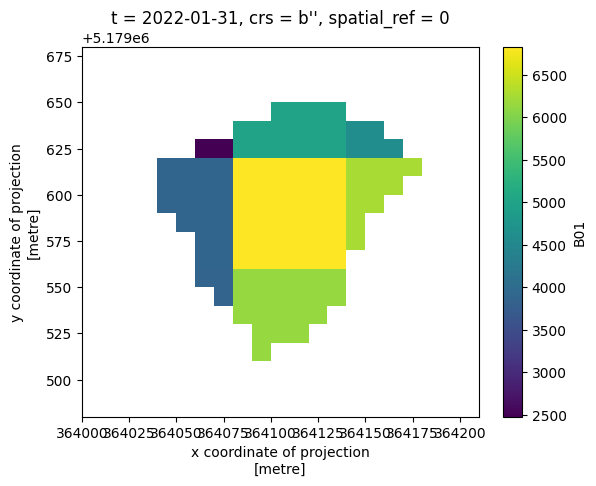

In [180]:
clipped['B01'][30].plot()

In [181]:
te_samples = np.vstack(all_pixels_ts)
te_samples = np.nan_to_num(te_samples, nan=-999999)

In [182]:
te_samples.shape

(420, 11, 365)

In [183]:
te_samples = te_samples.reshape(te_samples.shape[0], te_samples.shape[1]*te_samples.shape[2])
te_samples.shape

(420, 4015)

In [184]:
te_pred = clf.predict(te_samples)

In [185]:
df_normal = df.reset_index()
x = df_normal[['x', 'y']].values[:,0]
y = df_normal[['x', 'y']].values[:,1]

In [190]:
te_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

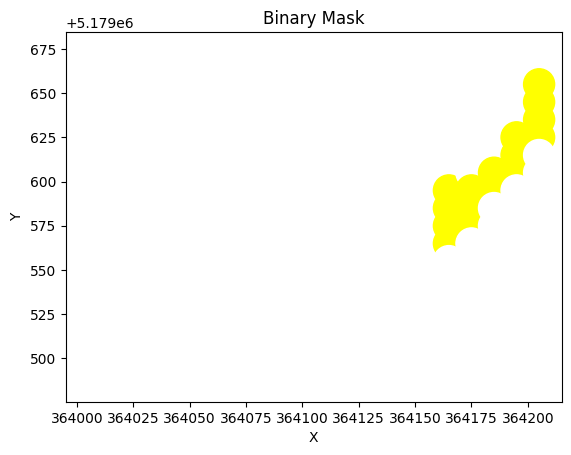

In [192]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['white', 'yellow']) #yellow for 1 and white for 0

# Plot the binary mask
plt.scatter(x, y, c=te_pred, cmap=custom_cmap, s=500)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binary Mask')
plt.show()